Project: Write a Datasciecne Blog Post

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import calendar
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

### Business Understanding
The following questions aim to be answered:
1. Which neighbourhood is the most popular to host an airbnb? The purpose of this question is to identify where to set up an airbnb
2. Which is the most popular month for bookings? the purpose of this is to prepeare the business calendar
3. Does price or reviews predict bookings? Which features predict this? The purpose of this question is to identify what booking qulities to invest in to increase the nuber of bookings.

### Data understanding
The datasets used in this analysis are
listings: includes details about listings including reviews, location and amenities
calendar: includes price and availability

### Prepare data

wrangle data

In [2]:
listings = pd.read_csv('listings.csv')

In [3]:
calendar_data = pd.read_csv('calendar.csv')
calendar_data=calendar_data[['listing_id', 'date', 'available']]
calendar_data

,listing_id,date,available
0,241032,2016-01-04,t
1,241032,2016-01-05,t
2,241032,2016-01-06,f
3,241032,2016-01-07,f
4,241032,2016-01-08,f
...,...,...,...
1393565,10208623,2016-12-29,f
1393566,10208623,2016-12-30,f
1393567,10208623,2016-12-31,f
1393568,10208623,2017-01-01,f


In [4]:
merge_data = listings.merge(calendar_data, how='left', left_on='id', right_on='listing_id')

clean data

In [5]:
def clean_data(listings):
    '''
    removes columns which I don't believe will be predictors such as ids and urls, removes null values 
    from weekly price, populate null values in columns with mean and modes,
    and change value types from string to float or string to boolean
    '''
    listings = listings.drop(
        ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered',
         'neighborhood_overview',
         'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_thumbnail_url',
         'host_about', 'host_url', 'host_name', 'host_id', 'first_review', 'last_review', 'calendar_last_scraped', 'street', 'host_verifications', 'price', 'amenities', 'host_picture_url'], axis=1)

    drop_predict = listings.dropna(subset=['weekly_price'], axis=0)
    loads = drop_predict.columns[np.sum(listings.isnull()) / listings.shape[0] > 0.5].tolist()
    clean_df = drop_predict.drop(loads, axis=1)
    category_columns = drop_predict.select_dtypes(include=['object']).columns.tolist()
    integer_columns = drop_predict.select_dtypes(include=['number']).columns.tolist()

    for column in clean_df:
        if isinstance(clean_df[[column]].iloc[0][0], str) and '$' in clean_df[[column]].iloc[0][0] :
            clean_df[column] = clean_df[column].str.replace('$','').str.replace(',','').astype(float)
        elif isinstance(clean_df[[column]].iloc[0][0], str) and '%' in clean_df[[column]].iloc[0][0]:
            clean_df[column] = clean_df[column].str.replace('%', '').astype(float)
        elif isinstance(clean_df[[column]].iloc[0][0], str) and clean_df[[column]].iloc[0][0] in ['t','f']:
            clean_df[column] = [ True if x == "t" else False for x in clean_df[column] ]
        elif isinstance(clean_df[[column]].iloc[0][0], str) and '-' in clean_df[[column]].iloc[0][0] and len(clean_df[[column]].iloc[0][0])==10:
            clean_df[f"{column}_days"] = pd.to_datetime(clean_df[column])
            clean_df[f"{column}_days"]=(pd.Timestamp.now() - clean_df[f"{column}_days"]).dt.days

        if clean_df[column].isnull().any():
            if (column in category_columns):
                clean_df[column] = clean_df[column].fillna(clean_df[column].mode()[0])
            elif (column in integer_columns):
                clean_df[column] = clean_df[column].fillna(clean_df[column].mean())

    return clean_df

In [6]:
clean_listings=clean_data(merge_data)
clean_listings.head(5)

/var/folders/p3/hcxmz1ws7hj2plm2hx190sx00000gp/T/ipykernel_48000/4281008403.py:21: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  clean_df[column] = clean_df[column].str.replace('$','').str.replace(',','').astype(float)
/var/folders/p3/hcxmz1ws7hj2plm2hx190sx00000gp/T/ipykernel_48000/4281008403.py:21: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  clean_df[column] = clean_df[column].str.replace('$','').str.replace(',','').astype(float)
/var/folders/p3/hcxmz1ws7hj2plm2hx190sx00000gp/T/ipykernel_48000/4281008403.py:21: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treat

,id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,...,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,listing_id,date,available,host_since_days,date_days
365,953595,2013-02-21,"Seattle, Washington, United States",within an hour,98.0,100.0,True,Queen Anne,6.0,6.0,...,strict,True,True,6,1.48,953595,2016-01-04,True,3956.0,2909
366,953595,2013-02-21,"Seattle, Washington, United States",within an hour,98.0,100.0,True,Queen Anne,6.0,6.0,...,strict,True,True,6,1.48,953595,2016-01-05,True,3956.0,2908
367,953595,2013-02-21,"Seattle, Washington, United States",within an hour,98.0,100.0,True,Queen Anne,6.0,6.0,...,strict,True,True,6,1.48,953595,2016-01-06,False,3956.0,2907
368,953595,2013-02-21,"Seattle, Washington, United States",within an hour,98.0,100.0,True,Queen Anne,6.0,6.0,...,strict,True,True,6,1.48,953595,2016-01-07,False,3956.0,2906
369,953595,2013-02-21,"Seattle, Washington, United States",within an hour,98.0,100.0,True,Queen Anne,6.0,6.0,...,strict,True,True,6,1.48,953595,2016-01-08,False,3956.0,2905


## Which neighbourhood is the most popular to host an airbnb?

In [7]:
def make_graph(data, cap, heading, x_axis, y_axis, x_label, y_label):
    '''
    method for creating bar graphs
    input: data and axes
    output: bar graph
    '''
    yvals=list(data[y_axis])[:cap]
    ind=list(data[x_axis])[:cap]
    width = 0.75
    barf = plt.bar(ind, yvals, width, color = 'b') 
    barf = plt.xticks(ind, ind, rotation='vertical')
    plt.title(heading)
    plt.ylabel(y_label)
    plt.xlabel(x_label)

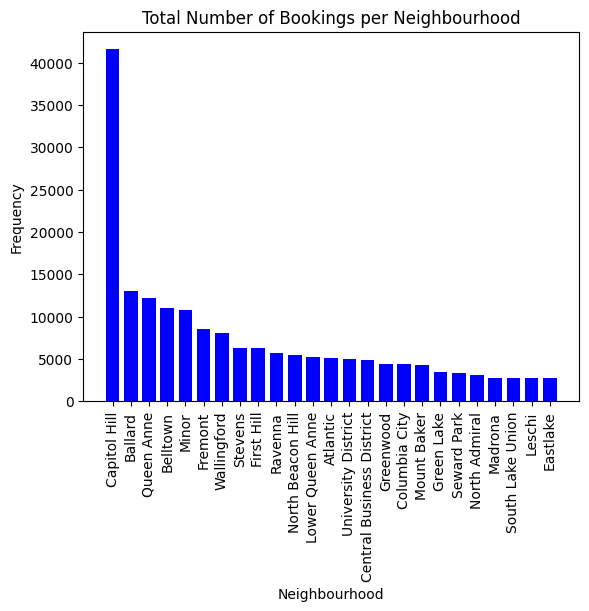

In [8]:
vis = clean_listings[clean_listings['available']==False]['neighbourhood'].value_counts().reset_index()
vis=vis.sort_values(by='neighbourhood', ascending=False)

heading='Total Number of Bookings per Neighbourhood'
y_label='Frequency'
x_label='Neighbourhood'
x_axis='index'
y_axis='neighbourhood'
make_graph(vis, 25, heading, x_axis, y_axis, x_label, y_label)

a=vis[:25]

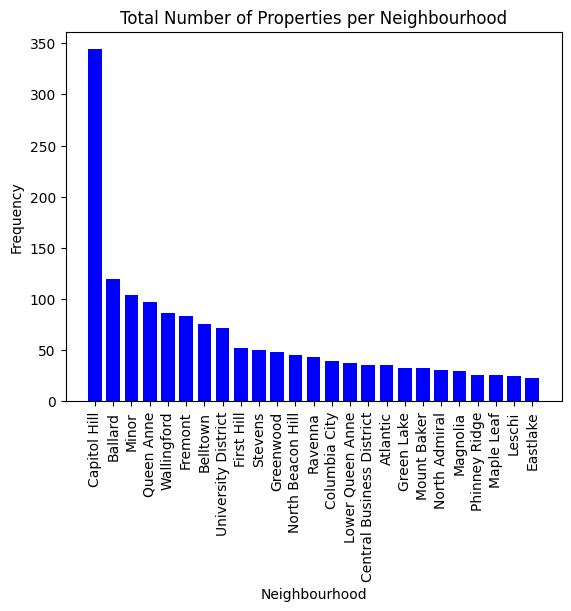

In [9]:
vis=clean_listings[['neighbourhood','id']].groupby(by=['neighbourhood','id']).mean().reset_index().copy()
vis = vis.groupby(by=['neighbourhood']).count().reset_index()
vis=vis.sort_values(by='id', ascending=False)
heading='Total Number of Properties per Neighbourhood'
y_label='Frequency'
x_label='Neighbourhood'
x_axis='neighbourhood'
y_axis='id'
make_graph(vis, 25, heading, x_axis, y_axis, x_label, y_label)
b=vis[:25]

In [10]:
# how many neighbourhoods are in the top 25 neighbourhoods
len(set(a['index']) & set(b['neighbourhood']))

22

In [11]:
plot_data = clean_listings[['neighbourhood','id']].groupby(by=['neighbourhood','id']).mean().reset_index().copy()

In [12]:
clean_listings['month'] = [ 
    calendar.month_name[datetime.datetime.strptime(d, '%Y-%m-%d').month] for d in clean_listings['date'] 
]
clean_listings['month_num'] = [ datetime.datetime.strptime(d, '%Y-%m-%d').month for d in clean_listings['date'] ]
clean_listings['year'] = [ datetime.datetime.strptime(d, '%Y-%m-%d').year for d in clean_listings['date'] ]

### Evaluate the results
A large number of properties appear in both lists. The most popular places to host are in Capitol hill. This can be interpretted to mean it is a saturated market or there is high demand.

## Which is the most popular month for bookings?

In [13]:
# prep the data prior to creating a monthly seasonality graphs
seasonality_prep = clean_listings[clean_listings['available']==False][['host_neighbourhood','date','month','month_num','year']]
seasonality_prep

,host_neighbourhood,date,month,month_num,year
367,Queen Anne,2016-01-06,January,1,2016
368,Queen Anne,2016-01-07,January,1,2016
369,Queen Anne,2016-01-08,January,1,2016
376,Queen Anne,2016-01-15,January,1,2016
377,Queen Anne,2016-01-16,January,1,2016
...,...,...,...,...,...
1392835,Capitol Hill,2016-12-29,December,12,2016
1392836,Capitol Hill,2016-12-30,December,12,2016
1392837,Capitol Hill,2016-12-31,December,12,2016
1392838,Capitol Hill,2017-01-01,January,1,2017


In [14]:
vis=seasonality_prep[['month','month_num']].value_counts().reset_index()
vis=vis.sort_values(by='month_num')
yvals=list(vis[0])
ind=list(vis['month'])
ind

['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

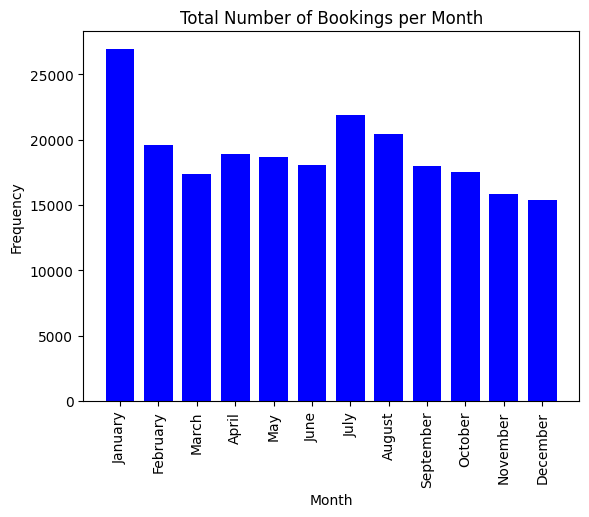

In [15]:
vis=seasonality_prep[['month','month_num']].value_counts().reset_index()
vis=vis.sort_values(by='month_num')
x_axis='month'
y_axis=0
heading='Total Number of Bookings per Month'
y_label='Frequency'
x_label='Month'
make_graph(vis, 12, heading, x_axis, y_axis, x_label, y_label)

### Evaluate the results
January is the most popular month for bookings which is surprising given the low number of books in december. The volume of bookings in July and August is also high which is expected.

## Which features most accurately predict bookings?
this is an exploratpry analysis of reviews and weekly_price to decide which produce the most interesting results. I hypothesise that these are the features people are most likeley to look for when booking an aibnb. What correlates with these features whould be taken into account when setting up a property.

Setting up functions

In [16]:
def create_dummy(df, cat_cols, dummy_na):
    '''
    create dummy variables for categorical data in sample
    '''
    for column in cat_cols:
        try:
            df = pd.concat([df.drop(column, axis=1), pd.get_dummies(df[column], prefix=column, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [17]:
# from udacity example
# returns the coefficients to determine which variable is the biggest predictor of price.
# parameter data_types is included so we can generate models depending on whether the variable is continuous or categorical.
def coefficients(df, data_types, predictor):
    '''
    returns the coefficients to determine which variable is the biggest predictor of price.
    parameter data_types is included so we can generate models depending on whether the variable is 
    continuous or categorical.
    '''
    if data_types=='object':
        cat_df = df.select_dtypes(include=['object']).columns.tolist()
        all_cols = df.select_dtypes(include=['object']).columns.tolist()
        all_cols.append(predictor)
        dummy = create_dummy(df[all_cols], cat_df, dummy_na=False)
        X =dummy.drop([predictor], axis=1)
    else:
        cat_df = df.select_dtypes(include=['object']).columns
        dummy = create_dummy(df, cat_df, dummy_na=False)
        X = dummy.select_dtypes(include=[data_types]).drop([predictor], axis=1)
    y = dummy[[predictor]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    lm_model = LinearRegression()
    lm_model.fit(X_train, y_train)
    cdf = pd.DataFrame({"Feature": X_train.columns.tolist(), "Coefficients": lm_model.coef_[0], "abs_coef": np.abs(lm_model.coef_[0])})
    return cdf

In [18]:
def make_regression_model(df,predictor):
    '''
    generates r2 value of data
    '''
    cat_df = df.select_dtypes(include=['object']).columns
    dummy = create_dummy(df, cat_df,dummy_na=False)
    X= dummy.drop([predictor], axis=1)
    y = dummy[[predictor]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    lm_model = LinearRegression()
    lm_model.fit(X_train, y_train)
    y_test_preds = lm_model.predict(X_test)
    test_score = r2_score(y_test, y_test_preds)
    return test_score

In [19]:
def availability_box_plot(data,predictor, title):
    '''
    create box plot of availability data
    '''
    available = clean_listings[clean_listings['available']==True][predictor]
    not_available = clean_listings[clean_listings['available']==False][predictor]

    data = [available, not_available]

    fig = plt.figure(figsize =(8, 5))
    ax = fig.add_subplot(111)

    bp = ax.boxplot(data, patch_artist = True,
                    notch ='True', vert = 0)

    colors = ['red', 'blue']

    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    for whisker in bp['whiskers']:
        whisker.set(color ='black',
                    linewidth = 1.5,
                    linestyle =":")


    # changing color and linewidth of
    # medians
    for median in bp['medians']:
        median.set(color ='black',
                   linewidth = 3)


    # x-axis labels
    ax.set_yticklabels(['available', 'booked'])

    # Adding title 
    plt.title(title)

    # Removing top axes and right axes
    # ticks
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

    # show plot
    plt.show()

In [20]:
def scatter_graph(x,y,x_label,y_label):
    '''
    create scatter graph with line of best fit
    '''
    #find line of best fit
    a, b = np.polyfit(x, y, 1)

    plt.xlabel(x_label, fontsize=15)
    plt.ylabel(y_label, fontsize=15)
    #add points to plot
    plt.scatter(x, y,s = 1)

    #add line of best fit to plot
    plt.plot(x, a*x+b)  

Weekly price

In [21]:
# exloratory analysis of predictors of weekly price

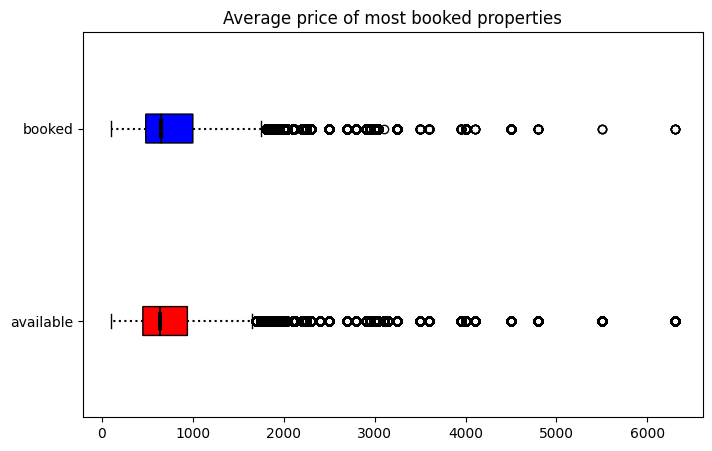

In [22]:
title="Average price of most booked properties"
availability_box_plot(clean_listings,'weekly_price', title)

The distribution of prices does not seem to differ between booked and available properties.

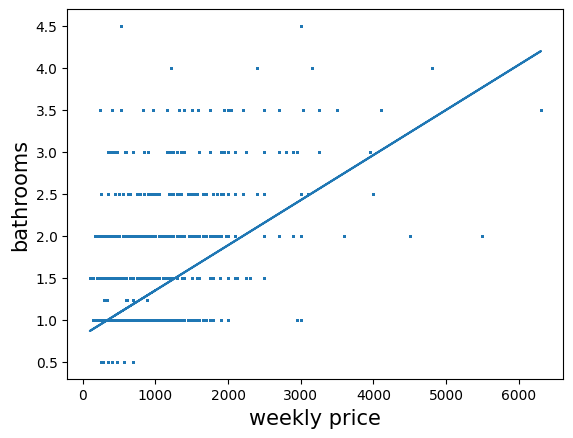

In [23]:
x = clean_listings['weekly_price']
y = clean_listings['bathrooms']
x_label='weekly price'
y_label='bathrooms'
scatter_graph(x,y,x_label,y_label)

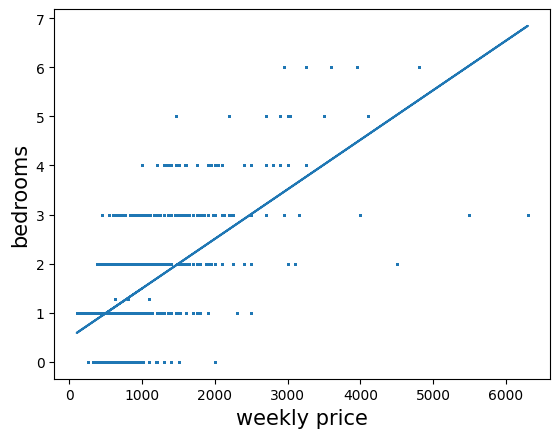

In [24]:
x = clean_listings['weekly_price']
y = clean_listings['bedrooms']
x_label='weekly price'
y_label='bedrooms'
scatter_graph(x,y,x_label,y_label)

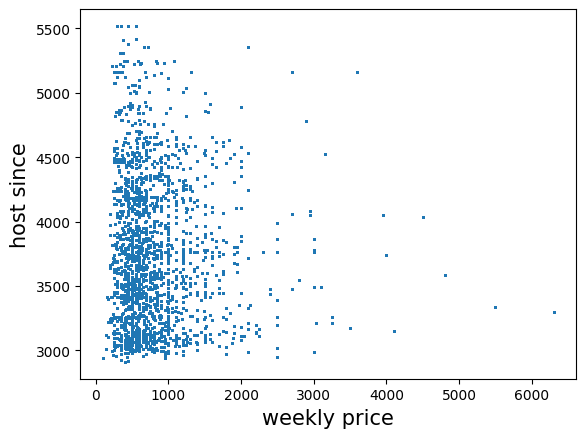

In [25]:
x = clean_listings['weekly_price']
y = clean_listings['host_since_days']
x_label='weekly price'
y_label='host since'
scatter_graph(x,y,x_label,y_label)

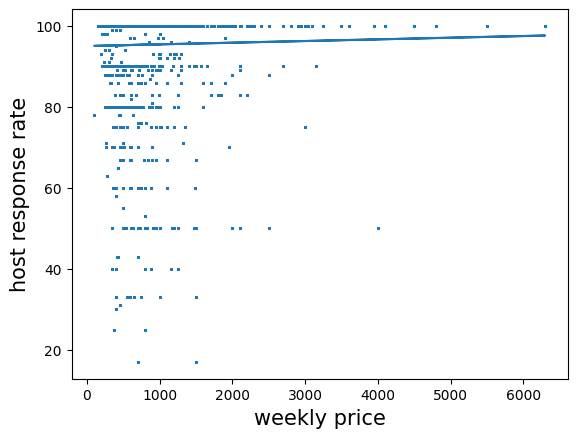

In [26]:
x = clean_listings['weekly_price']
y = clean_listings['host_response_rate']
x_label='weekly price'
y_label='host response rate'
scatter_graph(x,y,x_label,y_label)

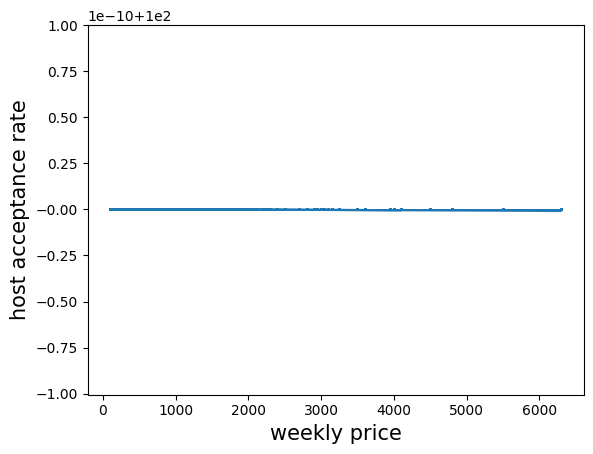

In [27]:
x = clean_listings['weekly_price']
y = clean_listings['host_acceptance_rate']
x_label='weekly price'
y_label='host acceptance rate'
scatter_graph(x,y,x_label,y_label)

In [28]:
make_regression_model(clean_listings[['weekly_price','bedrooms','bathrooms','neighbourhood']],'weekly_price')

0.5478428520672046

review scores rating

In [29]:
# exploratory analysis of predictors of review scores rating

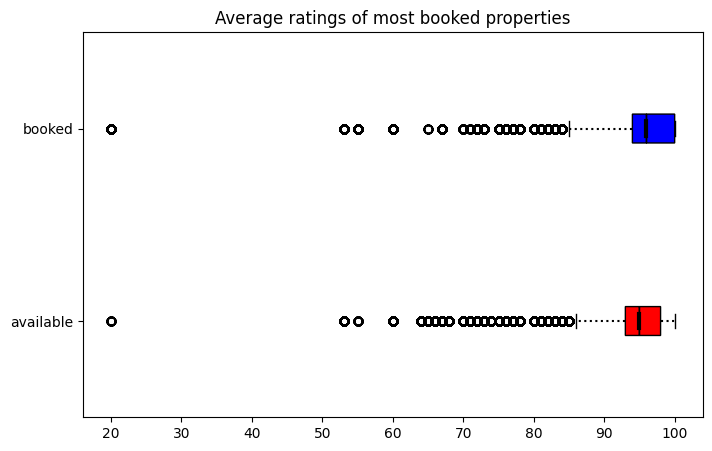

In [30]:
title="Average ratings of most booked properties"
availability_box_plot(clean_listings,'review_scores_rating', title)

Booked properties is more skewed towards hgher ratings than available properties. Review scores have a higher influence on bookings than price so i will perform a regression which features impact reviews.

In [31]:
clean_listings[[
    'weekly_price',
    'review_scores_accuracy', 
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'review_scores_rating'
]].corr()['review_scores_rating']

weekly_price                   0.042580
review_scores_accuracy         0.643295
review_scores_cleanliness      0.666595
review_scores_checkin          0.557854
review_scores_communication    0.583486
review_scores_location         0.405594
review_scores_value            0.718150
review_scores_rating           1.000000
Name: review_scores_rating, dtype: float64

<AxesSubplot: >

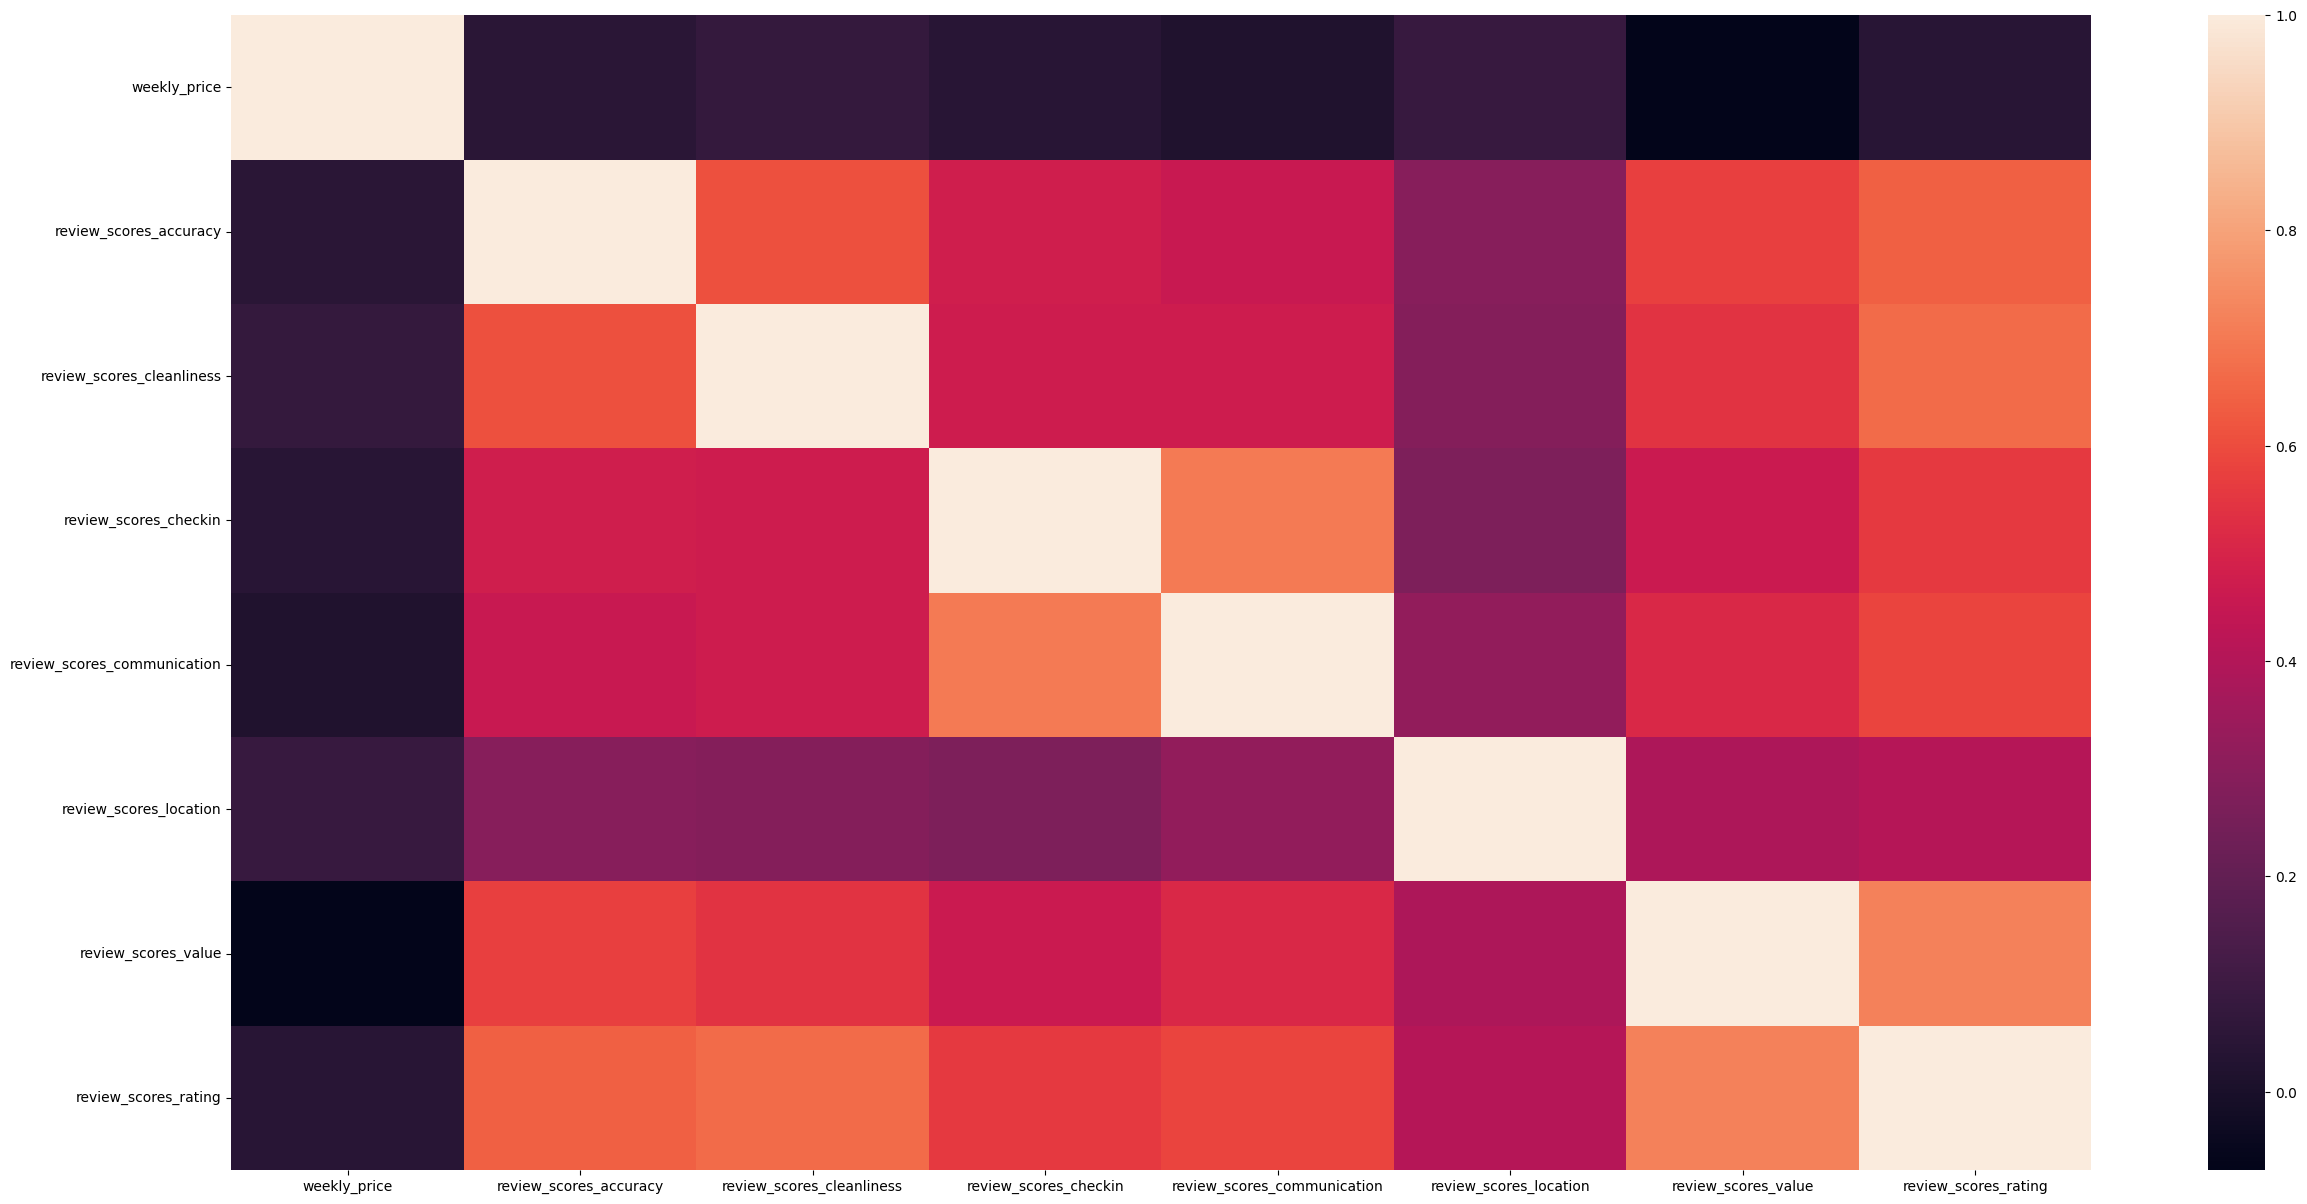

In [32]:
# Visualise correlations between review and price. Price has little association so can repeat this without
fig = plt.figure(figsize=(30,15))
ax = fig.gca()
sns.heatmap(
    clean_listings[[
        'weekly_price',
        'review_scores_accuracy', 
        'review_scores_cleanliness',
        'review_scores_checkin',
        'review_scores_communication',
        'review_scores_location',
        'review_scores_value',
        'review_scores_rating'
    ]].corr(), ax=ax
)

weekly price does not impact reviews so has been removed from the model.

<AxesSubplot: >

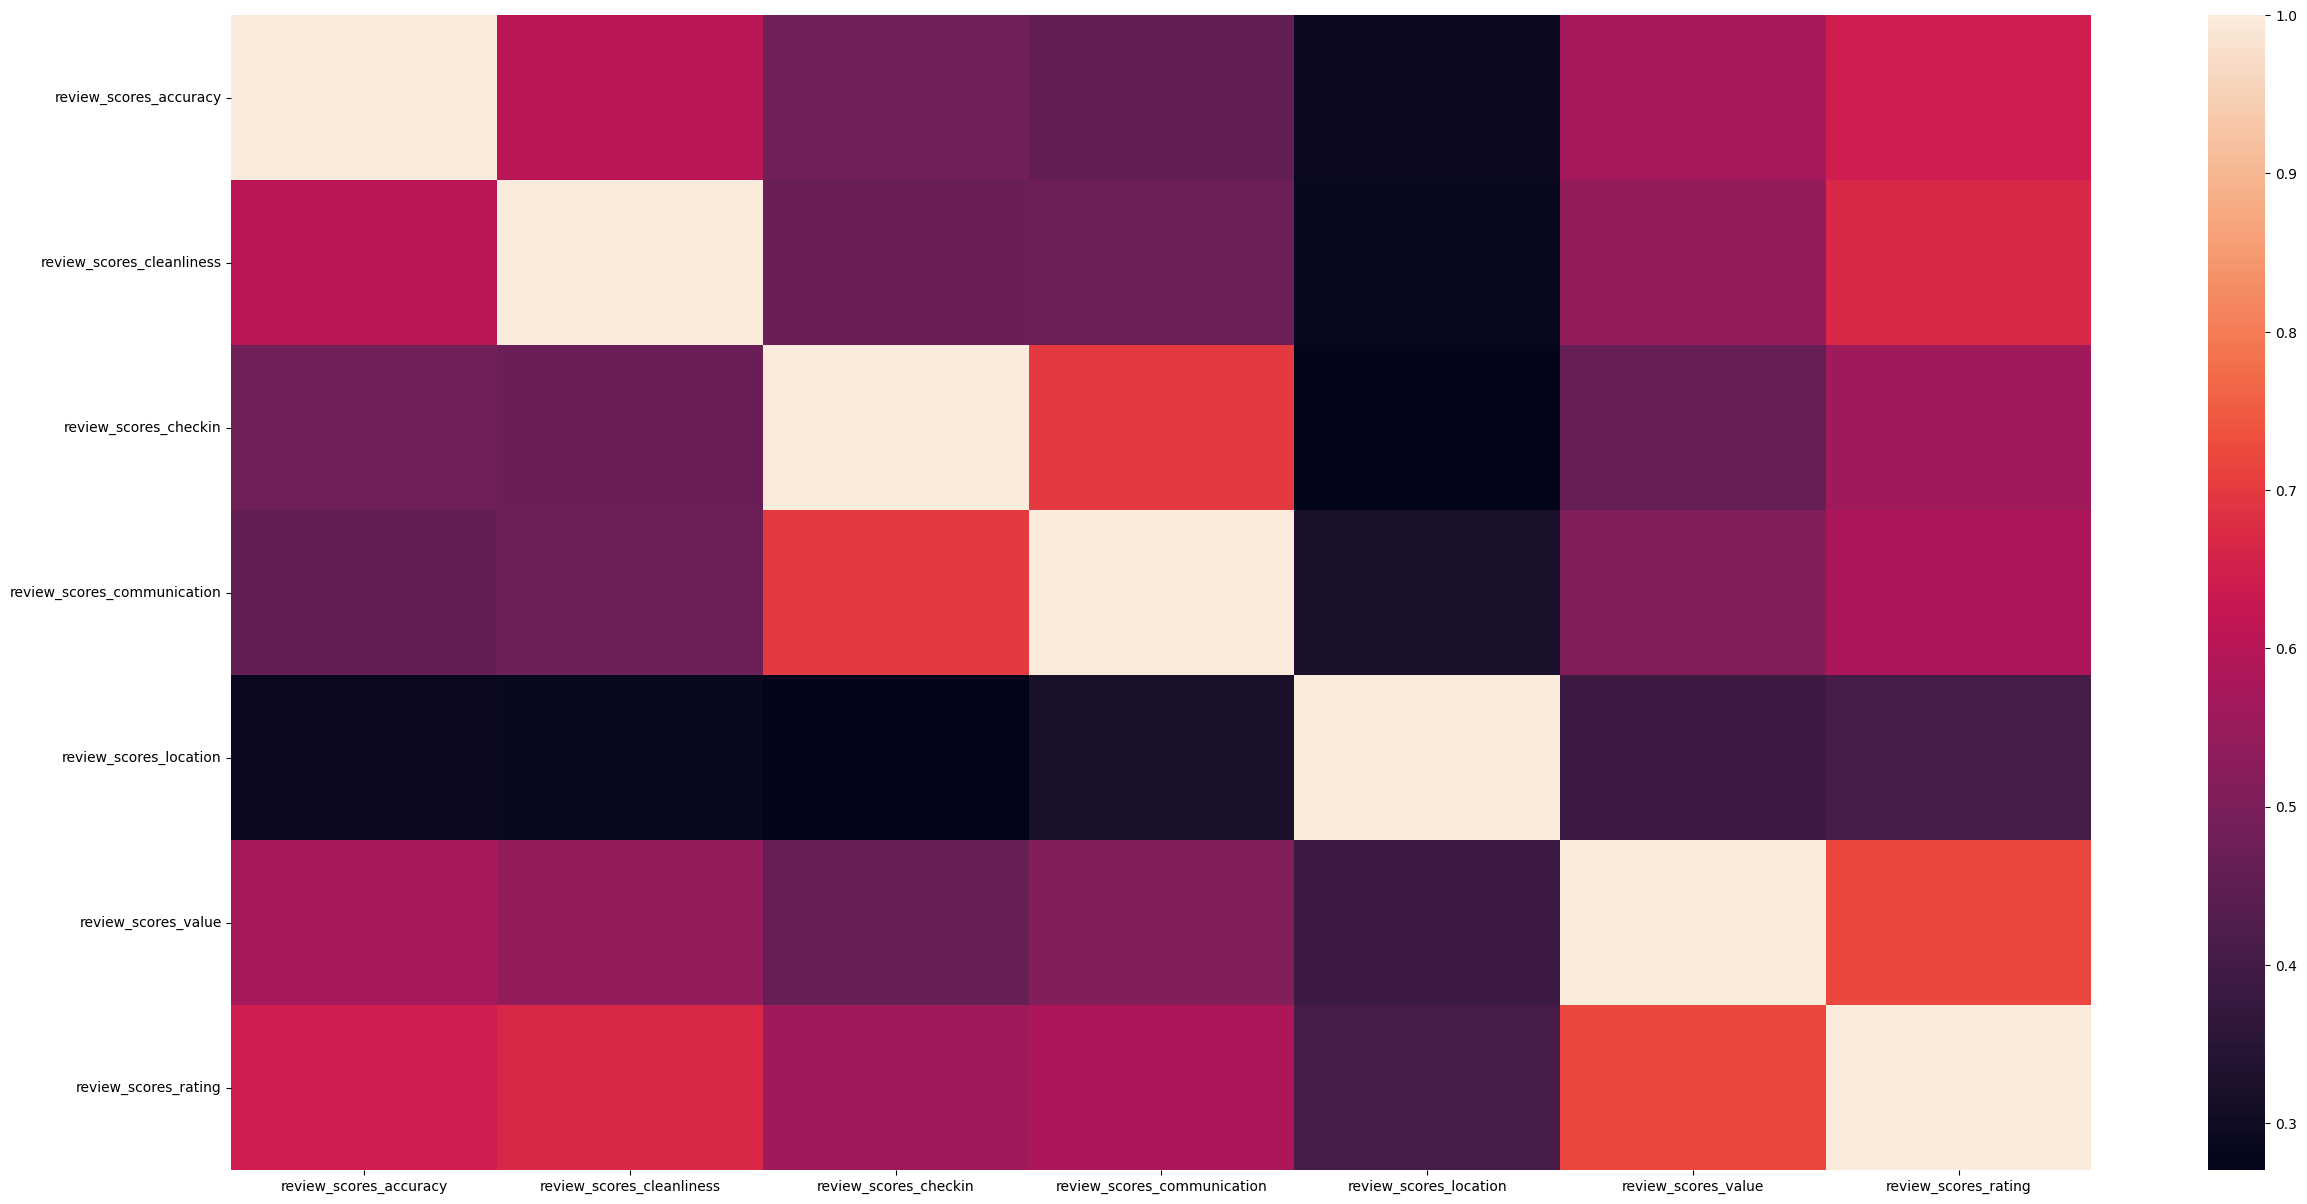

In [33]:
fig = plt.figure(figsize=(30,15))
ax = fig.gca()
sns.heatmap(clean_listings[['review_scores_accuracy',
                            'review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','review_scores_rating']].corr(), ax=ax)

In [34]:
coefficients(clean_listings[[
    'review_scores_accuracy', 
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'review_scores_rating'
]], 'number','review_scores_rating')

,Feature,Coefficients,abs_coef
0,review_scores_accuracy,1.540816,1.540816
1,review_scores_cleanliness,2.057636,2.057636
2,review_scores_checkin,1.031476,1.031476
3,review_scores_communication,1.329147,1.329147
4,review_scores_location,0.881805,0.881805
5,review_scores_value,3.068087,3.068087


In [35]:
# R^2 value for model including review values
make_regression_model(clean_listings[[
    'review_scores_accuracy', 
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'review_scores_rating'
]],'review_scores_rating')

0.6880099766688403

I hypothesises that neighbourhood has an impact on rating and therefore will include this int he regression model.

In [36]:
# R^2 value for model including review values and neighbourhood
make_regression_model(clean_listings[[
    'review_scores_accuracy', 
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'neighbourhood',
    'review_scores_rating'
]],'review_scores_rating')

0.700842878112462

### Evaluate the results
The feature which most heavily contributes to review scores is review score value which can be interpretted to mean 'value for money'. It was interesting to see that which neighbourhood the airbnb is hosted in does effect the ratings but only by a small amount. It increased form 0.688 to 0.700